### Checklist for submission

It is extremely important to make sure that:

1. Everything runs as expected (no bugs when running cells);
2. The output from each cell corresponds to its code (don't change any cell's contents without rerunning it afterwards);
3. All outputs are present (don't delete any of the outputs);
4. Fill in all the places that say `# YOUR CODE HERE`, or "**Your answer:** (fill in here)".
5. Never copy/paste any notebook cells. Inserting new cells is allowed, but it should not be necessary.
6. The notebook contains some hidden metadata which is important during our grading process. **Make sure not to corrupt any of this metadata!** The metadata may for example be corrupted if you copy/paste any notebook cells, or if you perform an unsuccessful git merge / git pull. It may also be pruned completely if using Google Colab, so watch out for this. Searching for "nbgrader" when opening the notebook in a text editor should take you to the important metadata entries.
7. Although we will try our very best to avoid this, it may happen that bugs are found after an assignment is released, and that we will push an updated version of the assignment to GitHub. If this happens, it is important that you update to the new version, while making sure the notebook metadata is properly updated as well. The safest way to make sure nothing gets messed up is to start from scratch on a clean updated version of the notebook, copy/pasting your code from the cells of the previous version into the cells of the new version.
8. If you need to have multiple parallel versions of this notebook, make sure not to move them to another directory.
9. Although not forced to work exclusively in the course `conda` environment, you need to make sure that the notebook will run in that environment, i.e. that you have not added any additional dependencies.

**FOR HA1, HA2 ONLY:** Failing to meet any of these requirements might lead to either a subtraction of points (at best) or a request for resubmission (at worst).

We advise you to perform the following steps before submission to ensure that requirements 1, 2, and 3 are always met: **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). This might require a bit of time, so plan ahead for this (and possibly use a cloud GPU in HA1 and HA2 for this step). Finally press the "Save and Checkout" button before handing in, to make sure that all your changes are saved to this .ipynb file.

### Fill in name of notebook file
This might seem silly, but the version check below needs to know the filename of the current notebook, which is not trivial to find out programmatically.

You might want to have several parallel versions of the notebook, and it is fine to rename the notebook as long as it stays in the same directory. **However**, if you do rename it, you also need to update its own filename below:

In [1]:
nb_fname = "HA2-Part1_Final.ipynb"

### Fill in group number and member names (use NAME2 and GROUP only for HA1 and HA2):

In [2]:
NAME1 = "Sky"
NAME2 = "Dani"
GROUP = "SkyDani"

### Check Python version

In [3]:
from platform import python_version_tuple

assert (
    python_version_tuple()[:2] == ("3", "11")
), "You are not running Python 3.11. Make sure to run Python through the course Conda environment."

### Check that notebook server has access to all required resources, and that notebook has not moved

In [4]:
import os

nb_dirname = os.path.abspath("")
assignment_name = os.path.basename(nb_dirname)
assert assignment_name in [
    "IHA1",
    "IHA2",
    "HA1",
    "HA2",
], "[ERROR] The notebook appears to have been moved from its original directory"

### Verify correct nb_fname

In [5]:
from IPython.display import HTML, display

try:
    display(
        HTML(
            r'<script>if("{nb_fname}" != IPython.notebook.notebook_name) {{ alert("You have filled in nb_fname = \"{nb_fname}\", but this does not seem to match the notebook filename \"" + IPython.notebook.notebook_name + "\"."); }}</script>'.format(
                nb_fname=nb_fname
            )
        )
    )
except NameError:
    assert False, "Make sure to fill in the nb_fname variable above!"

### Verify that your notebook is up-to-date and not corrupted in any way

In [6]:
import sys

sys.path.append("..")
from ha_utils import check_notebook_uptodate_and_not_corrupted

check_notebook_uptodate_and_not_corrupted(nb_dirname, nb_fname)

ModuleNotFoundError: No module named 'ha_utils'

# HA2 - Recurrent Neural Networks

This assignment is divided into two parts. In the first one, you will implement a vanilla RNN module from scratch using PyTorch to perform the task of predicting the nationality of a given name. In the second, you will implement many of the components in a Transformer block, and use it to classify movie reviews as positive or negative. 

For efficient use of GPU hours, you can do all development up until the training on a CPU. You can then run the training on a GPU for faster training times.

**IMPORTANT NOTES:**
Some cells contain compiled tests. For them to work propery, make sure to keep function and class names.
Similarly to IHA1, IHA2 and HA1 some questions in this notebook will not be graded in detail, but we still expect you to answer them. Those questions are marked with (0 points) and, as well as the other questions in this notebook, they may appear in the Inspera test.
You won’t need to train neural networks in Inspera test.

# Task 1 - Predicting Nationalities

In this task, you will create an RNN module using PyTorch, and train it to predict the nationality of a given input name. Your RNN will process each character of an input name at a time, and at the last character output a probability mass function over the possible countries.

The data for this task is present in the file `data/nam_dict.txt`. After parsing it we will have around 44k names from 41 different countries.

---
## 1.0 Imports

Import all dependencies

In [7]:
from utils.tests import ha2_part1_tests
%load_ext autoreload
%autoreload 2

from utils.load_names import get_data_from_file

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

---
## 1.1 Loading the data

We'll start by loading the data from the `nam_dict.txt` file, using the provided method `get_data_from_file`.

In [8]:
names_dict = get_data_from_file("data/nam_dict.txt")

The newly-created variable `names_dict` is a dictionary where each country is a key, and the value is the corresponding list of names from that country.

In [9]:
names_dict.keys()

dict_keys(['Great Britain', 'Ireland', 'U.S.A.', 'Italy', 'Portugal', 'Spain', 'France', 'the Netherlands', 'East Frisia', 'Germany', 'Swiss', 'Iceland', 'Denmark', 'Norway', 'Sweden', 'Finland', 'Estonia', 'Latvia', 'Lithuania', 'Hungary', 'Romania', 'Bulgaria', 'Bosnia and Herzegovina', 'Croatia', 'Kosovo', 'Serbia', 'Albania', 'Greece', 'Russia', 'Ukraine', 'Armenia', 'Azerbaijan', 'Kazakhstan/Uzbekistan,etc.', 'Turkey', 'Arabia/Persia', 'Israel', 'China', 'India/Sri Lanka', 'Japan', 'Korea', 'Vietnam'])

In [10]:
names_dict["Greece"][:10]

['Achilleas',
 'Achillefs',
 'Adamantia',
 'Adamantini',
 'Adamantios',
 'Aeneas',
 'Afroditi',
 'Agapi',
 'Agapios',
 'Agathi']

Let's look at the dataset in more detail. Plot the number of names in each country using a [bar plot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html).

*Hints*:

- You can put labels in the x-axis using the method [`xticks`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xticks.html).
- The `xticks` method accepts a keyword argument named `rotation`.

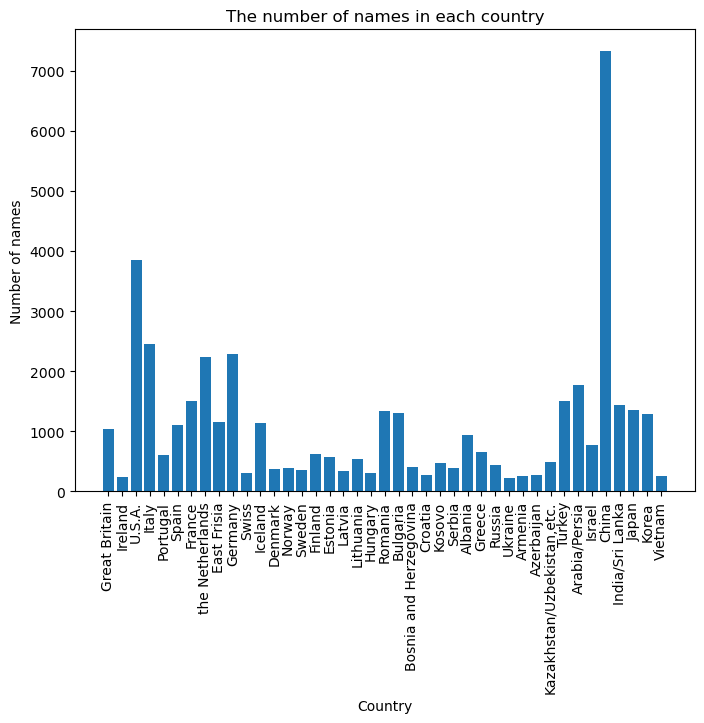

In [11]:
%matplotlib inline

# YOUR CODE HERE
names_count = [len(v) for v in names_dict.values()]
plt.figure(figsize=(8,6))
plt.bar(list(names_dict.keys()),names_count)
plt.title("The number of names in each country")
plt.xlabel("Country")
plt.ylabel("Number of names")
plt.xticks(rotation = 90)
plt.show()

**[0 point]** Is this dataset balanced? If not, which are the top-5 countries with most names?

**Your answer:** (This dataset is obviously seen imbalanced. The top-5 contries include China, U.S.A., Italy, Germany, and the Netherlands)

---
## 1.2 Pre-processing

We will train an RNN which takes as input one character at each time-step. In order to do so, we will encode every character in the input names into a one-hot representation that is more suited to be fed to neural networks. 

The first thing we need to do is to decide the size of the alphabet used for the one-hot encoding. To do so, let's take a look at all the characters used in the dataset. A simple way to do so is putting all names in the same string and then using a `set` to get the unique values. We'll treat upper-case and lower-case characters as being the same.

In [12]:
temp = " "
for name_list in names_dict.values():
    for name in name_list:
        temp += name.lower()
charset = sorted(set(temp))
print(f"{len(charset)} characters:")
charset

57 characters:


[' ',
 "'",
 '-',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'ß',
 'à',
 'á',
 'â',
 'ã',
 'ä',
 'å',
 'æ',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'í',
 'î',
 'ï',
 'ð',
 'ñ',
 'ò',
 'ó',
 'ô',
 'õ',
 'ö',
 'ø',
 'ú',
 'ü',
 'ý',
 'þ']

**[1 point]** We will now create a function that takes as input a name and the set of characters, and outputs a `(name length) x (charset length)` tensor, with each row being a one-hot encoding of the corresponding character. Complete the function below.

In [56]:
def name2tensor(name, charset):
    name = name.lower()

    tensor = None
    # YOUR CODE HERE
    name_length = len(name)
    charset_length = len(charset)
    
    name_onehot = np.zeros((name_length,charset_length))    

    for i,alphabet in enumerate(name):
        char_ind = charset.index(alphabet)
        name_onehot[i,char_ind] = 1 
    
    tensor = torch.from_numpy(name_onehot)
    tensor = tensor.to(torch.float32)
    
    return tensor

Run the following cell without changing anything to test your implementation of the above method. 

In [14]:
ha2_part1_tests.test_name2_tensor(name2tensor)

Test passed


Let us look at an example tensor for a name.

In [15]:
name2tensor("Ali", charset)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], dtype=torch.float64)

**[0 point]** Why does the above output tensor contain a 1 at position (0,3)?

**Your answer:** (Because "a" is at 4th position in the charset list after " ","'" and "-")

**[0 point]** What would if you try encoding the string `Lol@` using this function? Why?

**Your answer:** (It will have an error because "@" is not in the charset list.)

**[2 points]**

It's definitely possible to use the tensors created with `name2tensor` to train our RNN, but in that case we would only be able to conveniently perform forward-propagation using one sample at a time.

Instead, we want to batch samples together and parallelize the forward-propagation step. To do so, all samples must have the same dimensions (right now every sample has dimension `(name length) x (charset length)`, and the length of the names varies). Modify the function `name2padded_tensor` to achieve this by padding the start of the tensor with zeros, so that the output tensor always has length `target_len x (charset length)`.

*Hint*:

- To make it easier to catch bugs in the next parts of the assignment, make sure to raise an exception if the `target_len` is smaller than the length of the input word.

In [16]:
def name2padded_tensor(name, target_len, charset):
    tensor = name2tensor(name, charset)

    # YOUR CODE HERE
    name_length = len(name)

    if target_len < len(name):
        raise ValueError(f"target_len ({target_len}) is smaller than the length of the input name ({name_length}).")
    
    pad_value = target_len - name_length
    tensor = F.pad(tensor,(0,0,pad_value,0),"constant",0)       # pad (left,right,top,bottom)
    

    return tensor

In [17]:
ha2_part1_tests.test_name2padded_tensor(name2padded_tensor, charset)

Test passed.


**[1 point]** What should be the target length for our case in this dataset? Compute it (i.e. don't hardcode it) in the cell below and save it in a variable named `target_len`, which will be used from here on

In [18]:
# YOUR CODE HERE

target_len = 0

for country in names_dict.values():
    country_max_len_name = np.max([len(name) for name in country])
    target_len = np.max((country_max_len_name, target_len))





In [19]:
ha2_part1_tests.test_target_len(target_len)

Test passed


Now we can go through the entire dataset, encode each of the names, and save all of it in a tensor. We'll do the same with the ground-truth labels for the countries of each name.

In [20]:
# Create the tensors that will hold the names and labels
# (note that the first dimension has 0 elements, this is a way to initialize an empty tensor for concatenating later)
xs = torch.zeros(0, target_len, len(charset))
ys = torch.zeros(0, dtype=torch.long)

for i, country in enumerate(names_dict.keys()):
    # Apply the name2padded_tensor function to each name in this country
    temp = map(lambda n: name2padded_tensor(n, target_len, charset), names_dict[country])

    # Add a new dimension to the resulting tensors
    temp = [name_tensor[None, :, :] for name_tensor in temp]

    # Concatenate all of them along this new dimension
    names_tensor = torch.cat(temp, dim=0)

    # Add these tensors to `xs`
    # Note that we have 44504 data pairs (x,y) where a single input x has the shape (target_len, 57),
    # where 57 is the length of the one-hot-encoded vectors.
    xs = torch.cat([xs, names_tensor], dim=0)

    # Create tensor filled with i`s and add that to the ground-truth tensor
    ys_for_this_country = torch.zeros(names_tensor.shape[0], dtype=torch.long) + i
    ys = torch.cat([ys, ys_for_this_country])

In [21]:
xs.shape

torch.Size([44504, 22, 57])

In [22]:
ys.shape

torch.Size([44504])

Now we can create a dataset with these tensors.

In [23]:
from torch.utils.data import TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
dataset = TensorDataset(xs.to(device), ys.to(device))

Using cuda


And split it in training, validation, and test sets.

In [24]:
from torch.utils.data import random_split

val_ratio = 0.15
test_ratio = 0.15

n_samples = len(dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [n_train_samples, n_val_samples, n_test_samples]
)

---
### 1.3 Defining the optimization

Now we will define the model to be trained, that is, a single layer RNN. As usual, we will create a class for the model and inherit from `nn.Module`. Define in the next cell a class for an RNN that follows the equations:

$$ h_t = \text{tanh}(W_h x_t + U_h h_{t-1} + b_h) $$
$$ y_t = \log \Big(\text{Softmax}(W_y h_t + b_y)\Big)~,$$

where $h_t$ is the current hidden-state, $h_{t-1}$ is the previous hidden state, $x_t$ is the input, $y_t$ is the output, and $W_h, U_h, b_h, W_y, b_y$ are the trainable parts of the RNN. As explained before, we will use this RNN to classify names, inputting one character at each step and using the last output as the prediction for a distribution over probable countries for the name.

*Hints:*

- As you're probably aware by now, PyTorch [has a layer](https://pytorch.org/docs/stable/nn.html#logsoftmax) that already applies the log and the softmax in one pass.
- If you get errors related to size mismatches when computing the forward-propagation in your model, try reading the documentation for the specific module where the problem is occurring (e.g. [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#linear)), especially the part about the expected shape of inputs and outputs.

**[2 points]**

In [25]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Inputs:
            input_size     - Dimensionality of the input of this RNN.
            hidden_size    - Dimensionality of the hidden state.
            output_size    - Dimensionality of the output of this RNN.
        """
        #init
        super(RNN, self).__init__()

        #sizes
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        #hidden
        self.hidden_layer = nn.RNN(self.input_size, self.hidden_size, batch_first=True)

        #output
        self.last_layer = nn.Linear(self.hidden_size,self.output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, h):
        """
        Runs the RNN module for one time-step.
        Inputs:
            x              - Batch of one-hot encoded characters.
                             Tensor of size (BATCH SIZE x CHARSET LENGTH).
            h              - Batch of hidden states at previous time-step.
                             Tensor of size (BATCH SIZE x `hidden_size`).

        Returns:
            y              - Batch of outputs.
                             Tensor of size (BATCH SIZE x NUMBER OF COUNTRIES).
            new_h          - Batch of hidden states at current time-step.
                             Tensor of size (BATCH SIZE x `hidden_size`).
        """
        # Run the RNN layer
        #Num layers=1 so we can unsequeeze without caring
        h = h.unsqueeze(0) #Requirements: (num_layers,batch_size,hidden_size): 1x16x3

        #Time_steps to compute may change depending of x size
        dimensions=x.dim()

        #we only compute the next letter
        if dimensions==2:
            x = x.unsqueeze(1)  # Requirements: (Batch_size, Time_steps_to_compute,input size): 16x1x57
            rnn_out, new_h = self.hidden_layer(x, h)
        #we have more letters so we feed full x
        elif dimensions==3:
            rnn_out, new_h = self.hidden_layer(x, h)
        
        new_h = new_h.squeeze(0)  # Reshape from (1, 16, 3) to (16, 3) Required by the format to input again
        rnn_out= rnn_out[:, -1, :] #get last time step computed

        # Process the last hidden state output
        y = self.last_layer(rnn_out)  
        y = self.log_softmax(y)

        return y, new_h
ha2_part1_tests.test_model_output(RNN, device, names_dict, charset)

Test passed.


Run the following cell to test whether the shape of your outputs are correct. Note that this *only* checks the shapes and some basic ranges of outputs, not the content (one way you can check the actual computations of your network is to `print` the tensors as they pass through the layers, in order to check that the computations do what you expected).

In [26]:
ha2_part1_tests.test_model_output(RNN, device, names_dict, charset)

Test passed.


**[0 point]** Suppose we now create an RNN using the following call: `RNN(x, y, z)`. How many parameters would this model have in total?

**Your answer:** x is the input size, y is the hidden size, z is the output size.
Total Parameters 
​
 =$(x×y)+(y×y)+y+(y×z)+z$

We will use the Adam optimizer:

In [27]:
from torch.optim import Adam

And, since this is a classification problem we will use the negative log-likelihood loss ([`NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss)) to train the model. We should account for the fact that our dataset is imbalanced, and one way of dealing with this problem is to assign different weights to each class in our problem. More specifically, we want to give higher weights to examples belonging to the less frequent classes and lower weights to the more frequent ones.

In [28]:
# Compute weights for each class
n_names_for_each_country = [len(v) for v in names_dict.values()]
ns = torch.tensor(n_names_for_each_country, dtype=torch.float)
w = 1.0 / ns
w = w / w.sum()

 **[1 point]** Declare the appropriate weight criterion using the weights defined above.

In [29]:
# Define loss
criterion = nn.NLLLoss(weight=w).to(device)

In [30]:
ha2_part1_tests.test_criterion(criterion, device)

Test passed.


**[0 point]** Why is it a problem that the dataset is imbalanced? What would be the consequence of not dealing with this problem?

**Your answer:** The imbalanced dataset might lead to various problems and of course affect to model performance. If we do not tackle this issue, it can cause misleading accuracy. Moreover, poor generalization may happen because of the low accuracy on unseen data especially for the minor class.Because imagine a extreme case in which 99% of the names are from China and 1% are from the rest of the world. Then there would probably be a local minimum at 99% accuracy when predicting everything as China and we would be likely to not find any true relation.

**[0 point]** Why does assigning different weights to each class solve this problem?

**Your answer:** It has been studied that weight initialization is key to avoid vanishing gradient problems, so in an imbalanced dataset case we can also help weighting less the unimbalanced class. Moreover, it can help penalize model more for misclassification. This will enable model to pay attention to the minority classes during training.

**[0 point]** Is there any situation where *we would want* to introduce class imbalances in your dataset? How could we create such a class imbalance in a balanced dataset (without changing the dataset itself)?

**Your answer:** It can be very useful in order to test real case scenarios and model robustness. One could oversample from one class, or give a higher weights to a certain class in order to create this imbalance. One could also apply data augmentation, although you would need to apply a transformation to the dataset.

---
### 1.4 Helper functions for training

Now that we defined the optimization problem, we can start creating the code to actually solve it. The first thing that we need is a function that, given a batch of samples, computes the output of the model for every sample and the average loss across all samples. 

Complete the function `batch_forward_prop` to produce this behavior.

*Hints*:

- Initialize the hidden state to a zero Tensor for the first forward-propagation.
- If you get errors related to size mismatches when computing the forward-propagation in your model, try reading the documentation for the specific module where the problem is occurring (e.g. [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#linear)), especially the part about the expected shape of inputs and outputs.
- If you get errors related to size mismatches when computing the loss, try reading the [documentation for it](https://pytorch.org/docs/stable/nn.html#nllloss), especially the part about the expected shape of inputs and outputs.

**[2 points]**

In [31]:
def batch_forward_prop(rnn, xs, ys):
    """
    Inputs:
        rnn            - The RNN model, instance of the RNN class.
        xs             - Batch of input words.
                         Tensor of shape (BATCH SIZE x `target_len` x CHARSET LENGTH).
        ys             - Batch of ground-truth labels.
                         Tensor of  shape (BATCH_SIZE).

    Returns:
        output         - Output computed at the last character position in the batch.
                         Tensor of shape (BATCH_SIZE x NUMBER OF COUNTRIES).
        loss           - Value of the average loss across the predictions for this batch, later used for back-propagation.
                         Tensor with a single element inside.
    """

    # Initialize the hidden state to zeros
    h = torch.zeros(xs.size(0), rnn.hidden_size).to(device)  # Shape: (BATCH SIZE, hidden_size) rnn will unsquezee with 1 layer
    xs = xs.to(torch.float32)

    # Forward propagation through the RNN
    rnn_out, new_h = rnn(xs, h)  # Get the RNN outputs
 
    # Compute the loss using the output and ground truth labels
    loss = criterion(rnn_out, ys)  # criterion is defined externally, should handle the loss calculation

    return rnn_out, loss

Run the following cell to test whether the shape of your outputs are correct. Note that this *only* checks the shapes, not the content.

In [32]:
ha2_part1_tests.test_batch_forward_rnn(name2tensor_fn = name2tensor, 
                                       charset = charset,
                                       RNN_model = RNN,
                                       device = device,
                                       batch_forward_prop_fn = batch_forward_prop,
                                       names_dict = names_dict)

Test passed.


Using this function, it's straightforward to train on a single batch of data:

In [33]:
def train_batch(rnn, xs, ys, optimizer):
    # Compute the output for all samples in the batch and the average loss
    output, loss = batch_forward_prop(rnn, xs, ys)

    # Zero gradients before computing backward-propagation
    optimizer.zero_grad()

    # Backward-propagation
    loss.backward()

    # Clip the gradient norm (optional, helps to stabilize training)
    nn.utils.clip_grad_norm_(rnn.parameters(), 2)

    # Perform one step of optimization
    optimizer.step()

    return output, loss

We will also need a function for computing metrics of interest in the validation set. In this case, we will plot both the loss and the F1-score in the validation set. The F1-score of a classifier is the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of its [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall), two metrics that are more useful than accuracy for imbalanced datasets. [This blog post](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9) can help you to familiarize yourself with these new metrics.

In [34]:
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics_on_validation_set(rnn, val_dataset):
    # Get all the input and labels in the validation set.
    x_val, y_val = val_dataset[:]

    # Perform forward-prop in the entire validation set, with autograd disabled
    with torch.no_grad():
        val_output, val_loss = batch_forward_prop(rnn, x_val, y_val)

    # Get numpy arrays for the true labels and the predictions
    y_true = y_val.cpu().numpy()
    y_pred = val_output.argmax(dim=1).cpu().numpy()

    # Compute precision, recall, and F-score
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )

    return val_loss, precision, recall, fscore

Lastly, we define a function for plotting the metrics in real-time.

In [35]:
def plot_metrics(fig, ax, ns, train_losses, train_fscores, val_losses, val_fscores):
    # Plot losses
    ax[0].clear()
    ax[0].plot(ns, train_losses)
    ax[0].plot(ns, val_losses)
    ax[0].set_title("Loss")
    ax[0].legend(["Train", "Validation"])
    ax[0].set_xlabel("Number of trained batches")
    ax[0].grid()

    # Plot F1-scores
    ax[1].clear()
    ax[1].plot(ns, train_fscores)
    ax[1].plot(ns, val_fscores)
    ax[1].plot(ns, [0.3] * len(ns), "k--")
    ax[1].set_title("Macro F1-score")
    ax[1].legend(["Train", "Validation", "F1-score threshold"])
    ax[1].set_xlabel("Number of trained batches")
    ax[1].grid()

    fig.canvas.draw()

With these helper functions, the `train` function becomes:

In [36]:
from torch.utils.data import DataLoader
%matplotlib notebook

def train(rnn, n_epochs, learning_rate, batch_size, train_dataset, val_dataset):
    # Setup the figure for plotting progress during training
    
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
    plt.ion()
    plot_interval = 100

    # Create arrays to average training metrics across batches
    preds = []
    labels = []
    losses = []

    # Create dictionaries to hold the computed metrics in
    train_data = {"losses": [], "fscores": []}
    val_data = {"losses": [], "fscores": []}

    optimizer = Adam(rnn.parameters(), lr=learning_rate)
    train_data_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    batch_idxs = []

    # Training loop
    i_batch = 0
    for n in range(n_epochs):
        for i, (x_batch, y_batch) in enumerate(train_data_loader):
            i_batch += 1

            # Compute loss and outputs
            output, loss = train_batch(rnn, x_batch, y_batch, optimizer)

            # Aggregate for later averaging
            preds += output.argmax(dim=1).cpu().tolist()
            labels += y_batch.cpu().tolist()
            losses.append(loss)

            # Compute metrics and plot after every `plot_interval` batches
            if i % plot_interval == 0:
                val_loss, _, _, val_fscore = compute_metrics_on_validation_set(
                    rnn, val_dataset
                )
                train_fscore = precision_recall_fscore_support(
                    labels, preds, average="macro"
                )[2]

                val_data["losses"].append(val_loss.cpu())
                val_data["fscores"].append(val_fscore)
                train_data["losses"].append((sum(losses) / len(losses)).item())
                train_data["fscores"].append(train_fscore)
                batch_idxs.append(i_batch)

                preds = []
                labels = []
                losses = []

                plot_metrics(
                    fig,
                    ax,
                    batch_idxs,
                    train_data["losses"],
                    train_data["fscores"],
                    val_data["losses"],
                    val_data["fscores"],
                )
                
        print(f"Last step validation loss: {val_loss:.3f}, F1-score: {val_fscore:.3f}")

Make sure that you completely understand the `train` function before proceeding (e.g. that we aggregate predictions from different batches and compute metrics only at a certain interval, etc).

---
### 1.5 Training!

**[1 point]**
Now we're ready to train the network! Create an RNN and use the `train` function to train it.

*Hints*:

- Tuning the hyper-parameters (number of hidden units, learning rate, batch size, etc) will take some trial-and-error. Try simple things first, and then once you manage to train them, start scaling up. Also, have in mind the bias-variance tradeoff mentioned in the lectures.
- When tuning the learning rate, focus first on being able to decrease the training loss. Keep decreasing the learning rate until that starts happening.
- You should use a GPU for fast training times. Using a CPU, training a network can take ~5-10 minutes with suitable hyper-parameters. With a GPU training takes ~1 minute with the same hyper-parameters.

**Note:** If the interactive plots don't work, try to downgrade the notebook as following:

```!pip install notebook==6.5 traitlets==5.9```

In [37]:
# !pip install notebook==6.5 traitlets==5.9

Last step validation loss: 3.737, F1-score: 0.005
Last step validation loss: 3.384, F1-score: 0.013
Last step validation loss: 3.257, F1-score: 0.007
Last step validation loss: 3.204, F1-score: 0.011
Last step validation loss: 3.136, F1-score: 0.012
Last step validation loss: 3.041, F1-score: 0.024
Last step validation loss: 2.908, F1-score: 0.043
Last step validation loss: 2.751, F1-score: 0.066
Last step validation loss: 2.663, F1-score: 0.090
Last step validation loss: 2.571, F1-score: 0.094
Last step validation loss: 2.507, F1-score: 0.103
Last step validation loss: 2.455, F1-score: 0.114
Last step validation loss: 2.413, F1-score: 0.122
Last step validation loss: 2.375, F1-score: 0.131
Last step validation loss: 2.333, F1-score: 0.132
Last step validation loss: 2.303, F1-score: 0.142
Last step validation loss: 2.272, F1-score: 0.149
Last step validation loss: 2.253, F1-score: 0.158
Last step validation loss: 2.230, F1-score: 0.164
Last step validation loss: 2.208, F1-score: 0.168


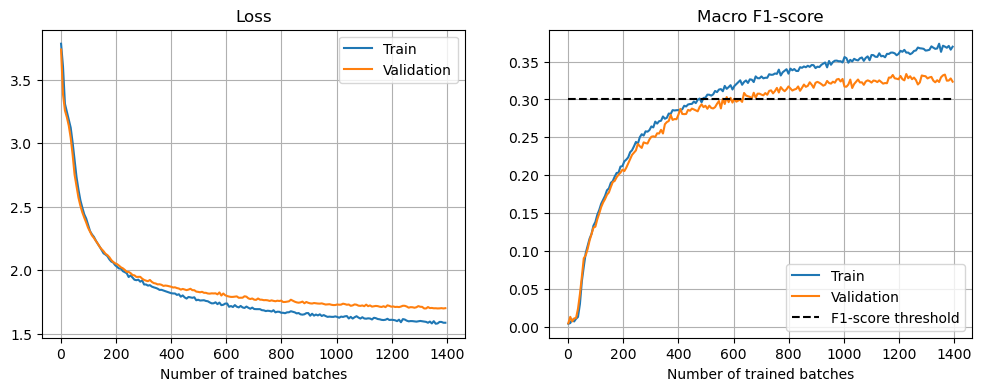

In [49]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# Define input size, hidden size, and output size
input_size = 57   # Charset length
hidden_size = 32  # Number of hidden units (you can adjust this)
output_size = 41  # Number of countries/classes

# Create the RNN instance
rnn = RNN(input_size, hidden_size, output_size)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn.to(device)

# Example of setting up the loss criterion
criterion = nn.NLLLoss()  # Negative log likelihood loss, ensure this is defined

# Set hyperparameters
n_epochs = 200           # Number of training epochs (adjust as necessary)
learning_rate = 0.005   # Learning rate (tune this as necessary)
batch_size = 2**12         # Batch size (tune this as necessary)

# Start the training process
train(rnn, n_epochs, learning_rate, batch_size, train_dataset, val_dataset)

In [50]:
_, _, _, fscore = compute_metrics_on_validation_set(rnn, val_dataset)
ha2_part1_tests.test_min_f1_score(fscore)

Test passed


---
### 1.6 Evaluation

Now that our model is trained, we can evaluate its predictions on the test set. 

In [51]:
# Get all samples from the test set
x_test, y_test = test_dataset[:]

# Compute predictions
with torch.no_grad():
    test_out, _ = batch_forward_prop(rnn, x_test, y_test)

# Transform them into hard predictions
preds = test_out.argmax(dim=1)

# Get `preds` as a numpy array
preds = preds.cpu().numpy()

Using these predictions, we can compute the confusion matrix on the test set as follows.

In [52]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
y_true = y_test.cpu().numpy()
cm = confusion_matrix(y_true, preds)
cm = cm.astype("float64")

# Normalize each row
for i in range(cm.shape[0]):
    cm[i, :] = cm[i, :] / sum(cm[i, :])

cm

array([[0.00662252, 0.        , 0.55629139, ..., 0.        , 0.00662252,
        0.        ],
       [0.        , 0.02222222, 0.37777778, ..., 0.        , 0.02222222,
        0.        ],
       [0.00537634, 0.00179211, 0.5609319 , ..., 0.00358423, 0.01075269,
        0.00179211],
       ...,
       [0.        , 0.        , 0.02512563, ..., 0.8040201 , 0.01005025,
        0.        ],
       [0.        , 0.        , 0.00505051, ..., 0.        , 0.68686869,
        0.01515152],
       [0.        , 0.        , 0.17777778, ..., 0.02222222, 0.13333333,
        0.24444444]])

In order to make this easier to visualize, let's plot it as a heat map:

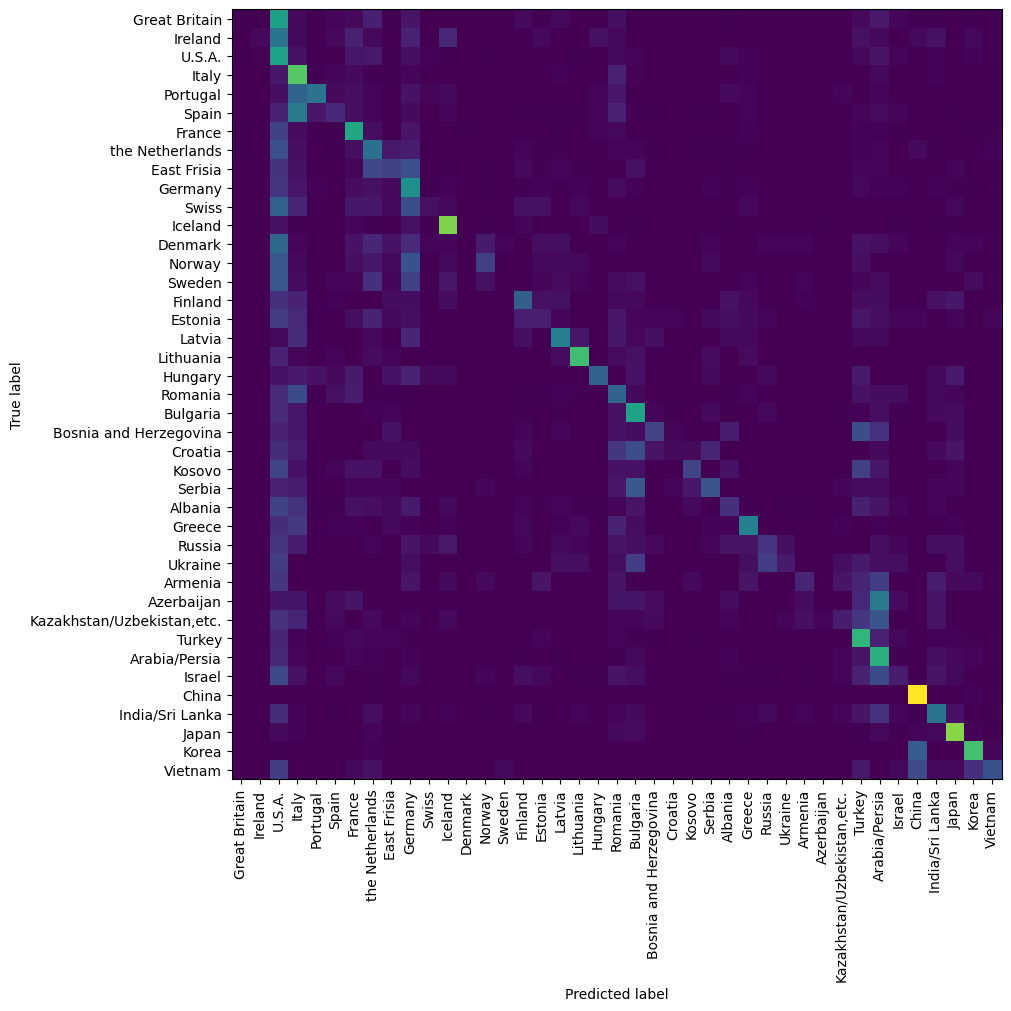

In [53]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(cm)
plt.xticks(range(len(names_dict)), names_dict.keys(), rotation="vertical")
plt.yticks(range(len(names_dict)), names_dict.keys())
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

**[0 point]** Why did we normalize the rows of the confusion matrix?

**Your answer:** It helps us interpret the classification performance more effectively by expressing the values as proportions of the total number of true instances for each class.

**[0 point]** What can you conclude from this confusion matrix? Which classes are easy/hard to classify? Which classes are being confused? 

**Your answer:** The model have the most accurate when predicting China because of the number of samples in the dataset, which is the majority of this dataset. As a result, it seems to be easy in classifying this class, following by Japan, and Iceland. On the contrary, the model is struggling in perform prediction in the following class ,Denmark, Sweden, Croatia, and Azerbaijan as we can see the color which representing the model performance. Furthermore, the model shows the most confusion between Great Britain and Ireland, as well as Arabia and Persia

To end this task, we can now define a function to perform predictions on any input name we provide (as long as the name contains only characters in our character set).

In [54]:
def evaluate(name_tensor):
    with torch.no_grad():
        hidden = torch.zeros(1, rnn.hidden_size).to(device)
        for i in range(name_tensor.shape[1]):
            output, hidden = rnn(name_tensor[:, i, :], hidden)
    return output.exp()


def predict(input_line, charset, n_predictions=5):
    tensor = name2tensor(input_line, charset).to(device)[None, :]
    output = evaluate(tensor)

    # Get top N categories
    topv, topi = output.topk(n_predictions, 1, True)
    topv, topi = topv[0], topi[0]

    cats = [list(names_dict.keys())[i] for i in topi.cpu().numpy()]
    vs = topv.cpu().numpy()

    plt.figure(figsize=(10, 3))
    plt.bar(range(len(vs)), vs)
    plt.xticks(range(len(vs)), cats)

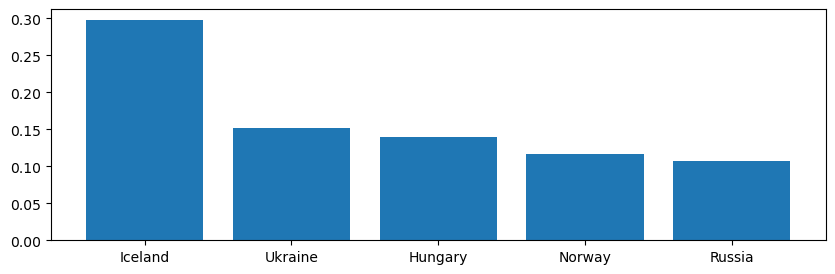

In [57]:
predict("Åsakvi", charset)

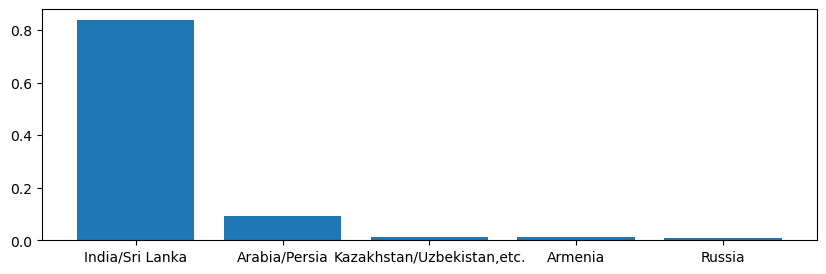

In [58]:
predict("Harakabim", charset)

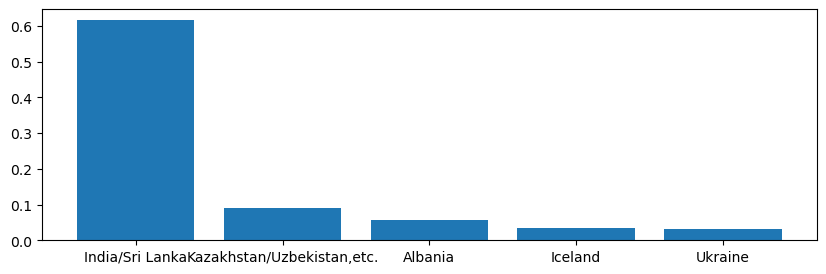

In [59]:
predict("Alakazam", charset)

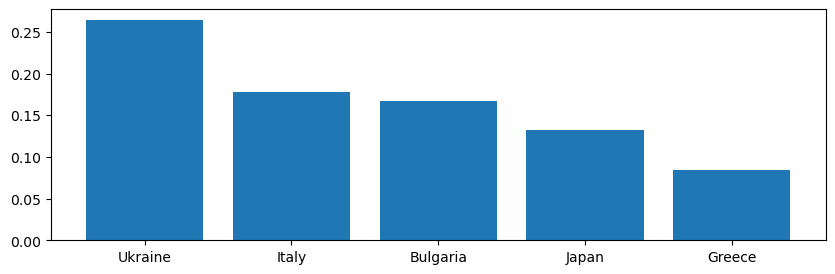

In [60]:
predict("Jin Quaio", charset)

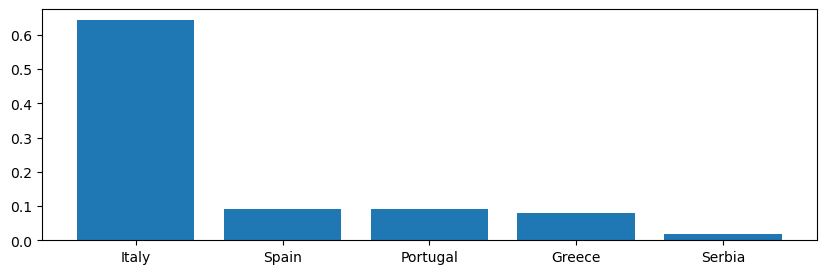

In [61]:
predict("Leonardino", charset)

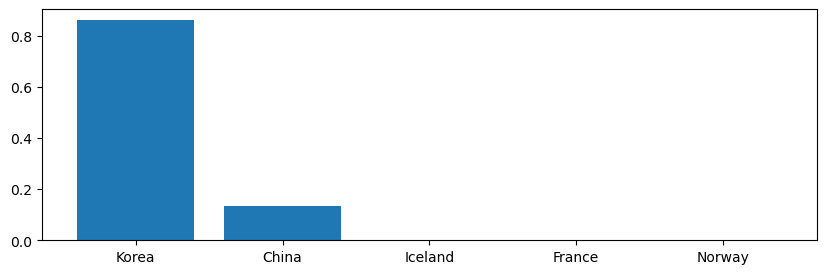

In [62]:
predict("Kim Sung", charset)

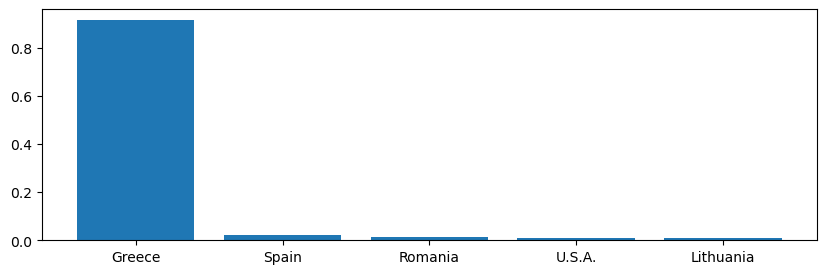

In [63]:
predict("Thanos", charset)

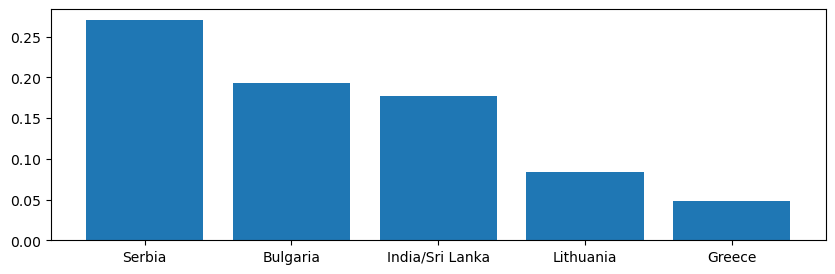

In [64]:
predict("Viiviika", charset)

Experiment on new names using the next cell:

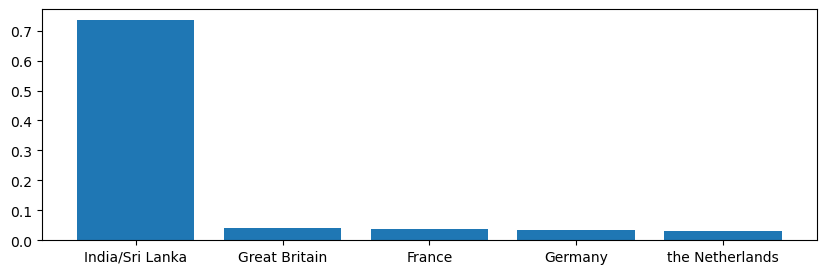

In [67]:
predict("Sky Sunsaksawat", charset)

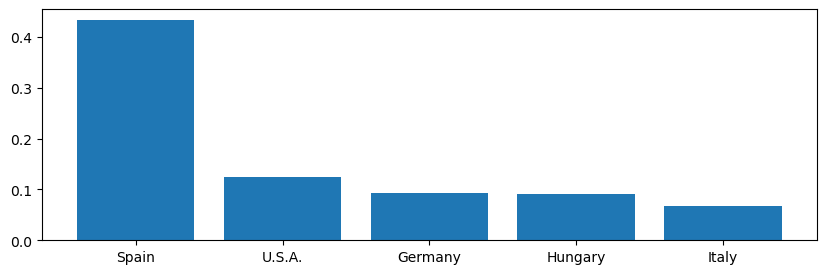

In [70]:
predict("Dani Gonzalez", charset)